In [10]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
from numpy.random import choice
import os.path

import tensorflow as tf
import numpy as np

In [2]:
tf.enable_eager_execution()

#### Import model, training function 

In [3]:
from annsa.model_classes import (dae_model_features,
                                 DAE,
                                 train_earlystop)

#### Load Dataset

In [4]:
dataset = np.load('../dataset_generation/hyperparametersearch_dataset_200keV_easy_log10time_1000.npy')

# all_spectra = np.random.poisson(np.add(np.array(dataset.item()['sources'], dtype=float),
#                                        np.array(dataset.item()['backgrounds'], dtype=float)))

all_spectra = np.random.poisson(np.add(np.array(dataset.item()['sources'], dtype=float),
                                       np.array(dataset.item()['backgrounds'], dtype=float)))

all_keys = np.array(dataset.item()['sources'], dtype=float) # background subtracted output

keys_raw = dataset.item()['keys'] # keys necessary for stratified


## Train network

In [72]:
earlystop_errors_test = []
model_id='dae-easy-final'

In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=5)


In [88]:

##########################
### Define Autoencoder ###
##########################
dense_nodes_encoder = [64]
dense_nodes_decoder = []


dae_features = dae_model_features(
    learning_rate=10**-4,
    l1_regularization_scale=0.0,
    dropout_probability=0.0,
    batch_size=2**8,
    output_size=1024,
    dense_nodes_encoder=dense_nodes_encoder,
    dense_nodes_decoder=dense_nodes_decoder,
    scaler=make_pipeline(FunctionTransformer(np.sqrt, validate=True)),
    activation_function=tf.nn.relu,
    output_function=None)

In [76]:
with open('../hyperparameter_search/hyperparameter-search-results/' + model_id, 'wb+') as f:
    pickle.dump(dae_features,f)

In [11]:

dae_optimizer = tf.train.AdamOptimizer(dae_features.learning_rate)

k_folds_errors = []
dae_models = []

k = 0

for train_index, test_index in sss.split(all_spectra, keys_raw):

    # reset model on each iteration
    dae_model = DAE(dae_features)
    dae_model.scaler.fit(all_spectra[train_index])

    ##########################
    #### Train Autoencoder ###
    ##########################

    costfunction_errors_dae_tmp, earlystop_errors_dae_tmp = train_earlystop(
        training_data=all_spectra[train_index],
        training_keys=all_keys[train_index],
        testing_data=all_spectra[test_index],
        testing_keys=all_keys[test_index],
        model=dae_model,
        optimizer=dae_optimizer,
        num_epochs=500,
        obj_cost=dae_model.mse,
        earlystop_cost_fn=dae_model.mse,
        earlystop_patience=10,
        verbose=True,
        fit_batch_verbose=1,
        data_augmentation=dae_model.poisson_data_augmentation)

    k_folds_errors.append(earlystop_errors_dae_tmp)
    dae_models.append(dae_model)
    dae_model.save_weights('./final-models/'+model_id+'_pretrained'+'_checkpoint_'+str(k))
    k += 1

INFO:tensorflow:Scale of 0 disables regularizer.
Epoch 1: CostFunc loss: 0.00 31.46, EarlyStop loss: 0.00 31.46
Epoch 2: CostFunc loss: 0.00 19.86, EarlyStop loss: 0.00 19.86
Epoch 3: CostFunc loss: 0.00 18.20, EarlyStop loss: 0.00 18.20
Epoch 4: CostFunc loss: 0.00 15.79, EarlyStop loss: 0.00 15.79
Epoch 5: CostFunc loss: 0.00 13.51, EarlyStop loss: 0.00 13.51
Epoch 6: CostFunc loss: 0.00 11.92, EarlyStop loss: 0.00 11.92
Epoch 7: CostFunc loss: 0.00 10.78, EarlyStop loss: 0.00 10.78
Epoch 8: CostFunc loss: 0.00 9.90, EarlyStop loss: 0.00 9.90
Epoch 9: CostFunc loss: 0.00 9.20, EarlyStop loss: 0.00 9.20
Epoch 10: CostFunc loss: 0.00 8.61, EarlyStop loss: 0.00 8.61
Epoch 11: CostFunc loss: 0.00 8.10, EarlyStop loss: 0.00 8.10
Epoch 12: CostFunc loss: 0.00 7.60, EarlyStop loss: 0.00 7.60
Epoch 13: CostFunc loss: 0.00 7.15, EarlyStop loss: 0.00 7.15
Epoch 14: CostFunc loss: 0.00 6.72, EarlyStop loss: 0.00 6.72
Epoch 15: CostFunc loss: 0.00 6.32, EarlyStop loss: 0.00 6.32
Epoch 16: CostFu

Epoch 132: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 133: CostFunc loss: 0.00 1.04, EarlyStop loss: 0.00 1.04
Epoch 134: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 135: CostFunc loss: 0.00 1.03, EarlyStop loss: 0.00 1.03
Epoch 136: CostFunc loss: 0.00 1.01, EarlyStop loss: 0.00 1.01
Epoch 137: CostFunc loss: 0.00 1.03, EarlyStop loss: 0.00 1.03
Epoch 138: CostFunc loss: 0.00 0.98, EarlyStop loss: 0.00 0.98
Epoch 139: CostFunc loss: 0.00 1.01, EarlyStop loss: 0.00 1.01
Epoch 140: CostFunc loss: 0.00 0.98, EarlyStop loss: 0.00 0.98
Epoch 141: CostFunc loss: 0.00 0.97, EarlyStop loss: 0.00 0.97
Epoch 142: CostFunc loss: 0.00 1.01, EarlyStop loss: 0.00 1.01
Epoch 143: CostFunc loss: 0.00 0.97, EarlyStop loss: 0.00 0.97
Epoch 144: CostFunc loss: 0.00 0.96, EarlyStop loss: 0.00 0.96
Epoch 145: CostFunc loss: 0.00 0.99, EarlyStop loss: 0.00 0.99
Epoch 146: CostFunc loss: 0.00 0.94, EarlyStop loss: 0.00 0.94
Epoch 147: CostFunc loss: 0.00 0.97, EarlyStop loss: 0.

Epoch 34: CostFunc loss: 0.00 3.59, EarlyStop loss: 0.00 3.59
Epoch 35: CostFunc loss: 0.00 3.48, EarlyStop loss: 0.00 3.48
Epoch 36: CostFunc loss: 0.00 3.41, EarlyStop loss: 0.00 3.41
Epoch 37: CostFunc loss: 0.00 3.39, EarlyStop loss: 0.00 3.39
Epoch 38: CostFunc loss: 0.00 3.35, EarlyStop loss: 0.00 3.35
Epoch 39: CostFunc loss: 0.00 3.30, EarlyStop loss: 0.00 3.30
Epoch 40: CostFunc loss: 0.00 3.26, EarlyStop loss: 0.00 3.26
Epoch 41: CostFunc loss: 0.00 3.18, EarlyStop loss: 0.00 3.18
Epoch 42: CostFunc loss: 0.00 3.11, EarlyStop loss: 0.00 3.11
Epoch 43: CostFunc loss: 0.00 3.11, EarlyStop loss: 0.00 3.11
Epoch 44: CostFunc loss: 0.00 3.03, EarlyStop loss: 0.00 3.03
Epoch 45: CostFunc loss: 0.00 3.00, EarlyStop loss: 0.00 3.00
Epoch 46: CostFunc loss: 0.00 2.94, EarlyStop loss: 0.00 2.94
Epoch 47: CostFunc loss: 0.00 2.89, EarlyStop loss: 0.00 2.89
Epoch 48: CostFunc loss: 0.00 2.86, EarlyStop loss: 0.00 2.86
Epoch 49: CostFunc loss: 0.00 2.84, EarlyStop loss: 0.00 2.84
Epoch 50

Epoch 166: CostFunc loss: 0.00 1.11, EarlyStop loss: 0.00 1.11
Epoch 167: CostFunc loss: 0.00 1.10, EarlyStop loss: 0.00 1.10
Epoch 168: CostFunc loss: 0.00 1.12, EarlyStop loss: 0.00 1.12
Epoch 169: CostFunc loss: 0.00 1.10, EarlyStop loss: 0.00 1.10
Epoch 170: CostFunc loss: 0.00 1.13, EarlyStop loss: 0.00 1.13
Epoch 171: CostFunc loss: 0.00 1.08, EarlyStop loss: 0.00 1.08
Epoch 172: CostFunc loss: 0.00 1.08, EarlyStop loss: 0.00 1.08
Epoch 173: CostFunc loss: 0.00 1.13, EarlyStop loss: 0.00 1.13
Epoch 174: CostFunc loss: 0.00 1.11, EarlyStop loss: 0.00 1.11
Epoch 175: CostFunc loss: 0.00 1.08, EarlyStop loss: 0.00 1.08
Epoch 176: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 177: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 178: CostFunc loss: 0.00 1.07, EarlyStop loss: 0.00 1.07
Epoch 179: CostFunc loss: 0.00 1.02, EarlyStop loss: 0.00 1.02
Epoch 180: CostFunc loss: 0.00 1.03, EarlyStop loss: 0.00 1.03
Epoch 181: CostFunc loss: 0.00 1.12, EarlyStop loss: 0.

Epoch 66: CostFunc loss: 0.00 2.46, EarlyStop loss: 0.00 2.46
Epoch 67: CostFunc loss: 0.00 2.47, EarlyStop loss: 0.00 2.47
Epoch 68: CostFunc loss: 0.00 2.41, EarlyStop loss: 0.00 2.41
Epoch 69: CostFunc loss: 0.00 2.41, EarlyStop loss: 0.00 2.41
Epoch 70: CostFunc loss: 0.00 2.36, EarlyStop loss: 0.00 2.36
Epoch 71: CostFunc loss: 0.00 2.33, EarlyStop loss: 0.00 2.33
Epoch 72: CostFunc loss: 0.00 2.31, EarlyStop loss: 0.00 2.31
Epoch 73: CostFunc loss: 0.00 2.30, EarlyStop loss: 0.00 2.30
Epoch 74: CostFunc loss: 0.00 2.27, EarlyStop loss: 0.00 2.27
Epoch 75: CostFunc loss: 0.00 2.23, EarlyStop loss: 0.00 2.23
Epoch 76: CostFunc loss: 0.00 2.25, EarlyStop loss: 0.00 2.25
Epoch 77: CostFunc loss: 0.00 2.18, EarlyStop loss: 0.00 2.18
Epoch 78: CostFunc loss: 0.00 2.18, EarlyStop loss: 0.00 2.18
Epoch 79: CostFunc loss: 0.00 2.13, EarlyStop loss: 0.00 2.13
Epoch 80: CostFunc loss: 0.00 2.14, EarlyStop loss: 0.00 2.14
Epoch 81: CostFunc loss: 0.00 2.12, EarlyStop loss: 0.00 2.12
Epoch 82

Epoch 197: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 198: CostFunc loss: 0.00 1.08, EarlyStop loss: 0.00 1.08
Epoch 199: CostFunc loss: 0.00 1.06, EarlyStop loss: 0.00 1.06
Epoch 200: CostFunc loss: 0.00 1.02, EarlyStop loss: 0.00 1.02
Epoch 201: CostFunc loss: 0.00 1.09, EarlyStop loss: 0.00 1.09
Epoch 202: CostFunc loss: 0.00 1.06, EarlyStop loss: 0.00 1.06
Epoch 203: CostFunc loss: 0.00 1.04, EarlyStop loss: 0.00 1.04
Epoch 204: CostFunc loss: 0.00 1.05, EarlyStop loss: 0.00 1.05
Epoch 205: CostFunc loss: 0.00 1.07, EarlyStop loss: 0.00 1.07
Epoch 206: CostFunc loss: 0.00 1.07, EarlyStop loss: 0.00 1.07
Epoch 207: CostFunc loss: 0.00 1.02, EarlyStop loss: 0.00 1.02
Epoch 208: CostFunc loss: 0.00 1.06, EarlyStop loss: 0.00 1.06
Epoch 209: CostFunc loss: 0.00 1.03, EarlyStop loss: 0.00 1.03
Epoch 210: CostFunc loss: 0.00 1.01, EarlyStop loss: 0.00 1.01
Epoch 211: CostFunc loss: 0.00 1.04, EarlyStop loss: 0.00 1.04
Epoch 212: CostFunc loss: 0.00 1.03, EarlyStop loss: 0.

Epoch 81: CostFunc loss: 0.00 2.47, EarlyStop loss: 0.00 2.47
Epoch 82: CostFunc loss: 0.00 2.42, EarlyStop loss: 0.00 2.42
Epoch 83: CostFunc loss: 0.00 2.40, EarlyStop loss: 0.00 2.40
Epoch 84: CostFunc loss: 0.00 2.37, EarlyStop loss: 0.00 2.37
Epoch 85: CostFunc loss: 0.00 2.35, EarlyStop loss: 0.00 2.35
Epoch 86: CostFunc loss: 0.00 2.31, EarlyStop loss: 0.00 2.31
Epoch 87: CostFunc loss: 0.00 2.32, EarlyStop loss: 0.00 2.32
Epoch 88: CostFunc loss: 0.00 2.30, EarlyStop loss: 0.00 2.30
Epoch 89: CostFunc loss: 0.00 2.25, EarlyStop loss: 0.00 2.25
Epoch 90: CostFunc loss: 0.00 2.21, EarlyStop loss: 0.00 2.21
Epoch 91: CostFunc loss: 0.00 2.19, EarlyStop loss: 0.00 2.19
Epoch 92: CostFunc loss: 0.00 2.19, EarlyStop loss: 0.00 2.19
Epoch 93: CostFunc loss: 0.00 2.13, EarlyStop loss: 0.00 2.13
Epoch 94: CostFunc loss: 0.00 2.12, EarlyStop loss: 0.00 2.12
Epoch 95: CostFunc loss: 0.00 2.09, EarlyStop loss: 0.00 2.09
Epoch 96: CostFunc loss: 0.00 2.09, EarlyStop loss: 0.00 2.09
Epoch 97

Epoch 212: CostFunc loss: 0.00 1.23, EarlyStop loss: 0.00 1.23
Epoch 213: CostFunc loss: 0.00 1.22, EarlyStop loss: 0.00 1.22
Epoch 214: CostFunc loss: 0.00 1.17, EarlyStop loss: 0.00 1.17
Epoch 215: CostFunc loss: 0.00 1.16, EarlyStop loss: 0.00 1.16
Epoch 216: CostFunc loss: 0.00 1.22, EarlyStop loss: 0.00 1.22
Epoch 217: CostFunc loss: 0.00 1.20, EarlyStop loss: 0.00 1.20
Epoch 218: CostFunc loss: 0.00 1.14, EarlyStop loss: 0.00 1.14
Epoch 219: CostFunc loss: 0.00 1.17, EarlyStop loss: 0.00 1.17
Epoch 220: CostFunc loss: 0.00 1.17, EarlyStop loss: 0.00 1.17
Epoch 221: CostFunc loss: 0.00 1.17, EarlyStop loss: 0.00 1.17
Epoch 222: CostFunc loss: 0.00 1.13, EarlyStop loss: 0.00 1.13
Epoch 223: CostFunc loss: 0.00 1.13, EarlyStop loss: 0.00 1.13
Epoch 224: CostFunc loss: 0.00 1.14, EarlyStop loss: 0.00 1.14
Epoch 225: CostFunc loss: 0.00 1.21, EarlyStop loss: 0.00 1.21
Epoch 226: CostFunc loss: 0.00 1.12, EarlyStop loss: 0.00 1.12
Epoch 227: CostFunc loss: 0.00 1.19, EarlyStop loss: 0.

Epoch 102: CostFunc loss: 0.00 1.54, EarlyStop loss: 0.00 1.54
Epoch 103: CostFunc loss: 0.00 1.55, EarlyStop loss: 0.00 1.55
Epoch 104: CostFunc loss: 0.00 1.53, EarlyStop loss: 0.00 1.53
Epoch 105: CostFunc loss: 0.00 1.53, EarlyStop loss: 0.00 1.53
Epoch 106: CostFunc loss: 0.00 1.50, EarlyStop loss: 0.00 1.50
Epoch 107: CostFunc loss: 0.00 1.52, EarlyStop loss: 0.00 1.52
Epoch 108: CostFunc loss: 0.00 1.58, EarlyStop loss: 0.00 1.58
Epoch 109: CostFunc loss: 0.00 1.47, EarlyStop loss: 0.00 1.47
Epoch 110: CostFunc loss: 0.00 1.46, EarlyStop loss: 0.00 1.46
Epoch 111: CostFunc loss: 0.00 1.45, EarlyStop loss: 0.00 1.45
Epoch 112: CostFunc loss: 0.00 1.49, EarlyStop loss: 0.00 1.49
Epoch 113: CostFunc loss: 0.00 1.48, EarlyStop loss: 0.00 1.48
Epoch 114: CostFunc loss: 0.00 1.48, EarlyStop loss: 0.00 1.48
Epoch 115: CostFunc loss: 0.00 1.42, EarlyStop loss: 0.00 1.42
Epoch 116: CostFunc loss: 0.00 1.41, EarlyStop loss: 0.00 1.41
Epoch 117: CostFunc loss: 0.00 1.48, EarlyStop loss: 0.

Epoch 233: CostFunc loss: 0.00 0.84, EarlyStop loss: 0.00 0.84
Epoch 234: CostFunc loss: 0.00 0.79, EarlyStop loss: 0.00 0.79
Epoch 235: CostFunc loss: 0.00 0.86, EarlyStop loss: 0.00 0.86
Epoch 236: CostFunc loss: 0.00 0.81, EarlyStop loss: 0.00 0.81
Epoch 237: CostFunc loss: 0.00 0.84, EarlyStop loss: 0.00 0.84
Epoch 238: CostFunc loss: 0.00 0.85, EarlyStop loss: 0.00 0.85
Epoch 239: CostFunc loss: 0.00 0.83, EarlyStop loss: 0.00 0.83
Epoch 240: CostFunc loss: 0.00 0.85, EarlyStop loss: 0.00 0.85
Epoch 241: CostFunc loss: 0.00 0.93, EarlyStop loss: 0.00 0.93
Epoch 242: CostFunc loss: 0.00 0.80, EarlyStop loss: 0.00 0.80
Epoch 243: CostFunc loss: 0.00 0.80, EarlyStop loss: 0.00 0.80
Test error at early stop: Objectives fctn: 0.79 Early stopfctn: 0.79


In [83]:
k_folds_errors

[[<tf.Tensor: id=2808811, shape=(), dtype=float32, numpy=0.6467122>],
 [<tf.Tensor: id=5772292, shape=(), dtype=float32, numpy=0.8895729>],
 [<tf.Tensor: id=8941933, shape=(), dtype=float32, numpy=0.9287891>],
 [<tf.Tensor: id=12034264, shape=(), dtype=float32, numpy=1.117917>],
 [<tf.Tensor: id=15165250, shape=(), dtype=float32, numpy=0.7887863>]]

In [84]:
dae_models

{0: <annsa.model_classes.DAE at 0x7f0c59667128>,
 1: <annsa.model_classes.DAE at 0x7f0c5608b588>,
 2: <annsa.model_classes.DAE at 0x7f0c561a2c18>,
 3: <annsa.model_classes.DAE at 0x7f0c5713e4a8>,
 4: <annsa.model_classes.DAE at 0x7f0d03126160>}

### Load model

In [13]:
dae_models = {}


for index in range(5):
    dae_models[index] = DAE(dae_features)
    dae_models[index].load_weights('./final-models/'+model_id+'_pretrained_checkpoint_'+str(index))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


### Run example data

isotope: 60CO


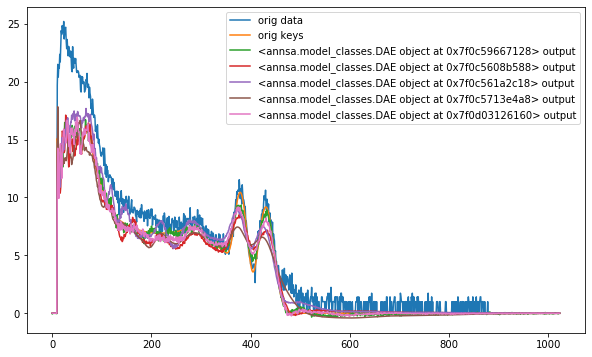

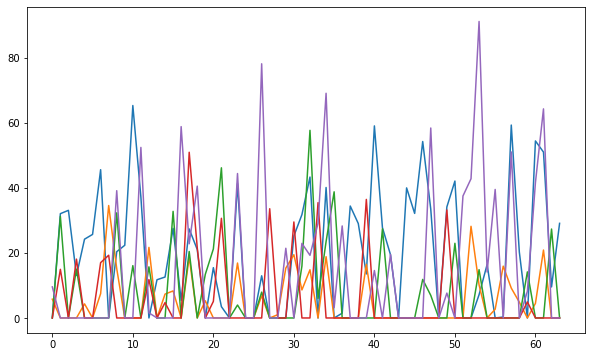

In [86]:
# index = 15012 # background
index = 1015

print('isotope: ' + keys_raw[index])
plt.figure(figsize=(10,6))
plt.plot(dae_models[1].scaler.transform(all_spectra[index:index+1])[0], label = 'orig data')
plt.plot(dae_models[1].scaler.transform(all_keys[index:index+1])[0], label = 'orig keys')

for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra[index:index+1])).numpy()[0], label = str(tmp_model)+' output')
    plt.legend()

plt.figure(figsize=(10,6))    
for model_index in dae_models:
    tmp_model = dae_models[model_index]    
    plt.plot(tmp_model.encoder(all_spectra[index:index+1]).numpy()[0])

In [16]:
from sklearn.decomposition import PCA

In [12]:
dae_model_bs_sqrt = DAE(dae_features)
dae_model_bs_sqrt.load_weights('./final-models/BS-DAE_draft_shielded_dataset_100_fwhm6_sqrt')

dae_model_bs_log10p = DAE(dae_features)
dae_model_bs_log10p.load_weights('./final-models/BS-DAE_draft_shielded_dataset_100_fwhm6_log10p')

dae_model_vanilla_sqrt = DAE(dae_features)
dae_model_vanilla_sqrt.load_weights('./final-models/VANILLA-DAE_draft_shielded_dataset_100_fwhm6_sqrt')

dae_model_vanilla_log10p = DAE(dae_features)
dae_model_vanilla_log10p.load_weights('./final-models/VANILLA-DAE_draft_shielded_dataset_100_fwhm6_log10p')

# Visualize 2D PCA of BS-DAE outputs 

In [13]:
def visualize_2d_PCA(model, dataset, plot=False):
    pca = PCA(n_components = 2)
    pca.fit(model.encoder(dataset).numpy())
    for k in range(100):
        for i in range(10):
            pca_vals = pca.transform(model.encoder(dataset[300*i+k:300*i+k+1]).numpy())[0][0:2]
            if plot == True:
                plt.scatter(pca_vals[0], pca_vals[1], label = str(i))
    return pca_vals

Text(0.5,1,'vanilla-DAE-sqrt')

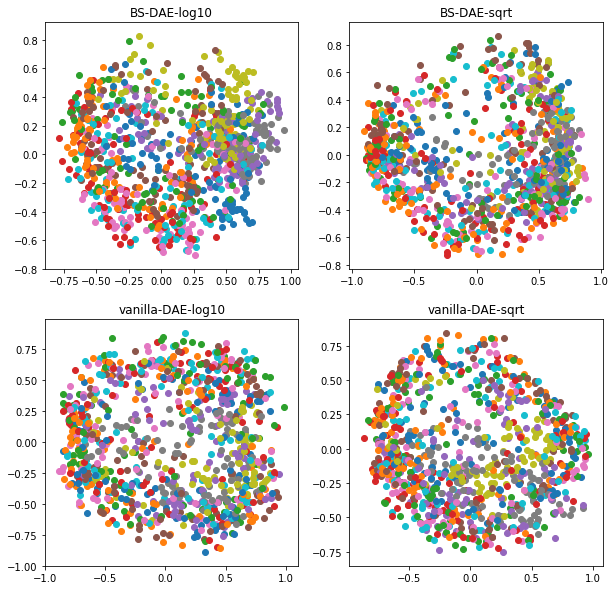

In [19]:
plt.figure(figsize=(10,10))

# BS-DAE-log10
plt.subplot(221)
visualize_2d_PCA(dae_model_bs_log10p, all_spectra, True)
plt.title('BS-DAE-log10')
plt.xlim([])

# BS-DAE-sqrt
plt.subplot(222)
visualize_2d_PCA(dae_model_bs_sqrt, all_spectra, True)
plt.title('BS-DAE-sqrt')

# vanilla-DAE-log10
plt.subplot(223)
visualize_2d_PCA(dae_model_vanilla_log10p, all_spectra, True)
plt.title('vanilla-DAE-log10')

# vanilla-DAE-sqrt
plt.subplot(224)
visualize_2d_PCA(dae_model_vanilla_sqrt, all_spectra, True)
plt.title('vanilla-DAE-sqrt')

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                    wspace=0.35)

### Visualize 2D PCA of preprocessed spectra 

Text(0.5,1,'sqrt')

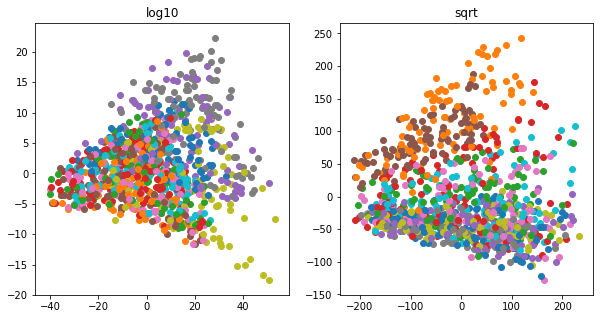

In [85]:

plt.figure(figsize=(10,5))

# log10
#plt.subplot(121)
plt.subplot(121)
pca = PCA(n_components=2)
pca.fit(np.log1p(all_spectra))
for k in range(100):
    for i in range(10):
        pca_vals = pca.transform(np.log1p(all_spectra[300*i+k:300*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0],pca_vals[1], label=str(i))
plt.title('log10')

# BS-DAE-sqrt
plt.subplot(122)
pca = PCA(n_components=2)
pca.fit(np.sqrt(all_spectra))
for k in range(100):
    for i in range(10):
        pca_vals = pca.transform(np.sqrt(all_spectra[300*i+k:300*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0],pca_vals[1], label=str(i))
plt.title('sqrt')

### Comparing output

In [79]:
all_models = [dae_model_bs_log10p,
              dae_model_bs_sqrt,
              dae_model_vanilla_log10p,
              dae_model_vanilla_sqrt]

In [97]:
tmp_model

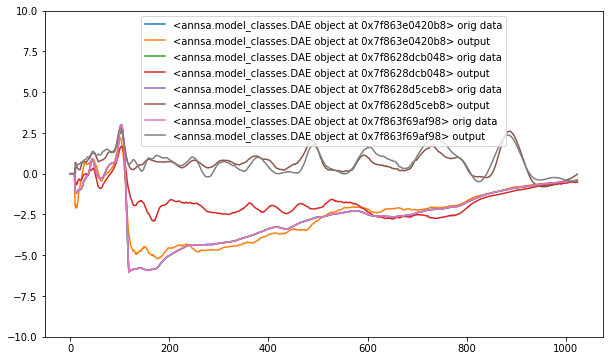

In [98]:
index = 850

plt.figure(figsize=(10,6))
for tmp_model in all_models:
    plt.plot(tmp_model.scaler.transform(all_source_spectra[index:index+1])[0], label = str(tmp_model)+' orig data')
    plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra[index:index+1])).numpy()[0], label = str(tmp_model)+' output')
plt.ylim([-10,10])
plt.legend()

# Use a dataset outside training

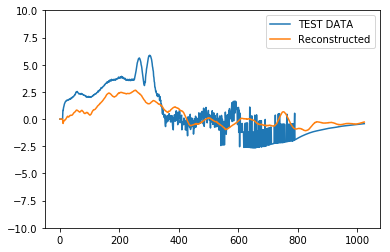

In [142]:
tmp_model = dae_model

index = 407

plt.plot(tmp_model.scaler.transform(all_spectra_TEST[index:index+1])[0], label='TEST DATA')
plt.plot(tmp_model.decoder(tmp_model.encoder(all_spectra_TEST[index:index+1])).numpy()[0], label='Reconstructed')
plt.ylim([-10,10])
plt.legend()

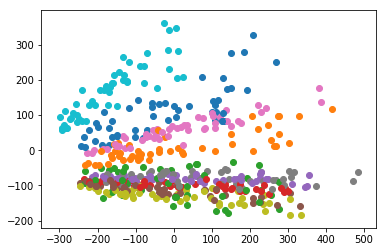

In [111]:
pca = PCA(n_components=2)
pca.fit(np.sqrt(all_spectra_TEST))

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(np.sqrt(all_spectra_TEST[125*i+k:125*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape

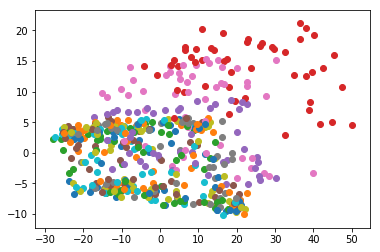

In [114]:
pca = PCA(n_components=2)
pca.fit(np.log1p(all_spectra_TEST))

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(np.log1p(all_spectra_TEST[125*i+k:125*i+k+1]))[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape

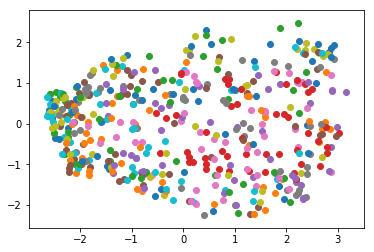

In [103]:
tmp_model = dae_model_vanilla_log10p

pca = PCA(n_components=2)
pca.fit(tmp_model.encoder(all_spectra_TEST).numpy())

for k in range(50):
    for i in range(10):
        pca_vals = pca.transform(tmp_model.encoder(all_spectra_TEST[125*i+k:125*i+k+1]).numpy())[0][0:2]
        plt.scatter(pca_vals[0], pca_vals[1], label=all_keys_TEST[i])
#plt.legend()
# all_spectra.shape